In [1]:
''' Início: Importações e tratamento de dados '''
###########################################################################################


import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential  # Modelo sequencial de camadas
from tensorflow.keras.layers import Dense       # Camadas fully connected
from tensorflow.keras import backend as K       # Funções dentro de Keras, para criar nova função
from tensorflow.keras import optimizers         
import matplotlib.pyplot as plt



# Tratamento usando pandas
base = pd.read_csv("../Datasets/growatt.csv")
# Verificar se existem valores nulos
print(base.isna().sum())

# Tirar o tempo, pois não é relevante
base = base.drop('Time', axis=1)

# Tornar os dados normalizados entre[-1, 1]
def normalizar(X):
    Xproc = np.zeros_like(X)
    Natr = X.shape[1]
    for ii in range(Natr):
        M = max(X[:,ii])
        m = min(X[:,ii])
        Xproc[:,ii] = (X[:,ii]-m)/(M-m)
        
    return Xproc

Nepochs = 100     # numero de epocas/steps/iterations
Nbatch  = 5    # numero de padroes no treinamento modo mini-batch

Time       0
Vpv1       0
Vpv2       0
Vpv3       0
Vpv4       0
Vpv5       0
Vpv6       0
Vpv7       0
Ipv1       0
Ipv2       0
Ipv3       0
Ipv4       0
Ipv5       0
Ipv6       0
Ipv7       0
INVTemp    0
Ppv        0
Pac        0
dtype: int64


In [2]:
''' Tratamento usando numpy '''
###########################################################################################

base = base.to_numpy()
base = base[0:-6,:] # tira 6 linhas para arredondar o número de amostras
base[:,15] = base[:,15]/1000   # Transforma Watts em kWatts para facilitar leitura
base[:,16] = base[:,16]/1000   # Transforma Watts em kWatts para facilitar leitura


base_n = base

# Permuta padroes aleatoriamente
index = np.random.permutation(base.shape[0])
base = base[index,:]

# Processa os dados de entrada por atributo
base_n = normalizar(base)

# Separa dados para treinamento e teste
Ntotal = base_n.shape[0]
Ntrain = int(Ntotal*0.6) # 60% para treinamento e validacao
Ntest = Ntotal-Ntrain    # 40% restantes para teste

X_train = base_n[0:Ntrain,0:-1] # primeira ate a penultima coluna
y_train = base[0:Ntrain:,-1].astype(float)   # ultima coluna

X_test = base_n[Ntrain+1:,0:-1] # primeira ate a penultima coluna
y_test = base[Ntrain+1:,-1].astype(float)   # ultima coluna

In [3]:
''' Construindo o modelo '''
###########################################################################################

def relu2x(X):
    return 2*K.relu(X)



model = Sequential([
        # a primeira camada deve fornecer a dimensao dos dados de entrada
        Dense(64, activation= relu2x, input_shape=(X_train.shape[1],)),
        # as camadas subsequentes fazem inferencia automatica da dimensao
        Dense(64, activation= relu2x),
        Dense(64, activation= relu2x),
        Dense(1), # 1 neuronio linear (sem funcao de ativacao)
        ])

In [4]:
''' Compilando rede'''
###########################################################################################

model.compile(optimizer=optimizers.Adamax(), 
              loss='mse',
              metrics=['mae','mse'],
              )


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                1088      
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 9,473
Trainable params: 9,473
Non-trainable params: 0
_________________________________________________________________


In [5]:
''' treinando o modelo (invocar a funcao fit()) '''
########################################################################################### 
history = model.fit(X_train,
          y_train,
          epochs=Nepochs,
          batch_size=Nbatch,
          shuffle=True,
          validation_split=1/4,
          )
'''
    Estamos salvando a evolucao do treinamento no objeto
    history
    '''
''''''

Epoch 1/100
174/174 [==============================] - 1s 3ms/step - loss: 916.9979 - mae: 23.4795 - mse: 916.9979 - val_loss: 165.1918 - val_mae: 11.2438 - val_mse: 165.1918
Epoch 2/100
174/174 [==============================] - 0s 2ms/step - loss: 58.1645 - mae: 5.6268 - mse: 58.1645 - val_loss: 3.1299 - val_mae: 1.4347 - val_mse: 3.1299
Epoch 3/100
174/174 [==============================] - 0s 2ms/step - loss: 3.2495 - mae: 1.3292 - mse: 3.2495 - val_loss: 2.0873 - val_mae: 1.0933 - val_mse: 2.0873
Epoch 4/100
174/174 [==============================] - 0s 2ms/step - loss: 2.6074 - mae: 1.1583 - mse: 2.6074 - val_loss: 1.8033 - val_mae: 1.0147 - val_mse: 1.8033
Epoch 5/100
174/174 [==============================] - 0s 2ms/step - loss: 2.2448 - mae: 1.0567 - mse: 2.2448 - val_loss: 1.8788 - val_mae: 1.0994 - val_mse: 1.8788
Epoch 6/100
174/174 [==============================] - 0s 2ms/step - loss: 2.0297 - mae: 0.9936 - mse: 2.0297 - val_loss: 1.4753 - val_mae: 0.9004 - val_mse: 1.475

''

In [6]:
''' testando o modelo '''
########################################################################################### 

print('\nTeste:\n')
model.evaluate(X_test,
               y_test,
               )


Teste:

25/25 [==============================] - 0s 1ms/step - loss: 0.1042 - mae: 0.2065 - mse: 0.1042


[0.10423748940229416, 0.20647817850112915, 0.10423748940229416]

In [7]:
''' usando o modelo para predicao da saida (processar os dados e ter uma decisao) '''
########################################################################################### 

# Processa as 5 primeiras imagens de teste
predictions = model.predict(X_test[:10])
np.set_printoptions(formatter={'float': lambda x: "{0:0.2f}".format(x)})
print('\nnotas estimadas/preditas:\n{}'.format(predictions.reshape(10,))) 
print('notas verdadeiras correspondentes:\n{}'.format(y_test[:10]))


notas estimadas/preditas:
[74.92 13.29 74.94 63.81 20.03 75.11 27.39 74.94 75.00 75.10]
notas verdadeiras correspondentes:
[75.03 13.18 74.98 63.64 20.15 74.98 27.28 74.94 74.93 75.01]


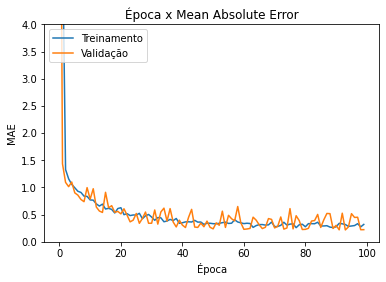

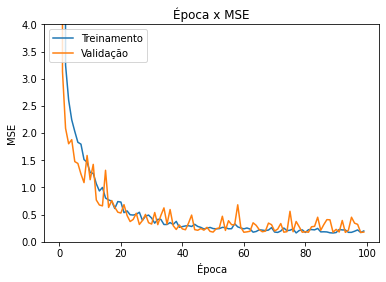

In [8]:
''' imprimindo resultados do treinamento '''
########################################################################################### 

plt.figure()
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Época x Mean Absolute Error')
plt.ylabel('MAE')
plt.xlabel('Época')
plt.ylim(0,4)


plt.legend(['Treinamento', 'Validação'], loc='upper left')

plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Época x MSE')
plt.ylabel('MSE')
plt.xlabel('Época')
plt.ylim(0,4)
plt.legend(['Treinamento', 'Validação'], loc='upper left')

Text(0.5, 0, 'Amostras')

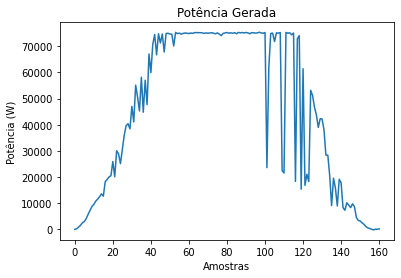

In [14]:
base2 = pd.read_csv("../Datasets/growatt.csv")
# Tirar o tempo, pois não é relevante
base2 = base2.drop('Time', axis=1)

base2 = base2.to_numpy()
base2 = base2[0:-6,:] # tira 6 linhas para arredondar o número de amostras
base2[:,15] = base2[:,15]/1000   # Transforma Watts em kWatts para facilitar leitura
base2[:,16] = base2[:,16]/1000   # Transforma Watts em kWatts para facilitar leitura

base_n2 = normalizar(base2)

X_train2 = base_n2[0:,0:-1] # primeira ate a penultima coluna
y_train2 = base2[:,-1].astype(float)   # ultima coluna

predictions2 = model.predict(X_train2[319:480])
predictions2 = predictions2*1000
plt.plot(predictions2)
plt.title('Potência Gerada')
plt.ylabel('Potência (W)')
plt.xlabel('Amostras')


Text(0, 0.5, 'Valores reais')

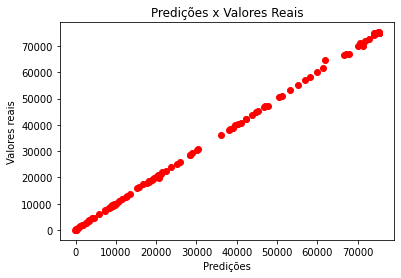

In [19]:
plt.plot(predictions2, y_train2[319:480]*1000,'ro')
plt.title('Predições x Valores Reais')
plt.xlabel('Predições')
plt.ylabel('Valores reais')
